In [1]:
import bnpy
import numpy as np
import os
from scipy import stats

import matplotlib
from matplotlib import pylab
%matplotlib inline

np.set_printoptions(suppress=1, precision=3)

FIG_SIZE = (10, 5)
pylab.rcParams['figure.figsize'] = FIG_SIZE

In [2]:
def sample_hmm(N, T, K, D):
    alpha = np.full(K, 1.0)
    #print alpha
    
    pi0 = stats.dirichlet.rvs(alpha).reshape(K)
    #print pi0, pi0.sum()
    pi = stats.dirichlet.rvs(alpha, size=K)
    #print pi, pi.sum(axis=1)
    mu = stats.norm.rvs(np.tile(np.arange(0, 10*K, 10), (D, 1)).T, size=(K, D))
    #print mu
    
    # t = 1
    states = np.zeros((N, T), dtype=int)
    obs = np.zeros((N, T, D))
    states[:, 0] = np.random.choice(K, size=N, replace=True, p=pi0)
    obs[:, 0, :] = stats.norm.rvs(loc=mu[states[:, 0]], scale=5)
    
    # t = 2, ..., T
    for n in xrange(N):
        for t in xrange(1, T):
            states[n, t] = np.random.choice(K, p=pi[states[n, t-1]])
            obs[n, t, :] = stats.norm.rvs(loc=mu[states[n, t]], scale=5)
    
    return states, obs, mu

In [3]:
N, T, K, D = 100, 10, 5, 2
states, obs, mu = sample_hmm(N, T, K, D)

In [4]:
X = obs.reshape((N*T, D))
doc_range = np.arange(0, N*T+1, T)
dataset = bnpy.data.GroupXData(X, doc_range)

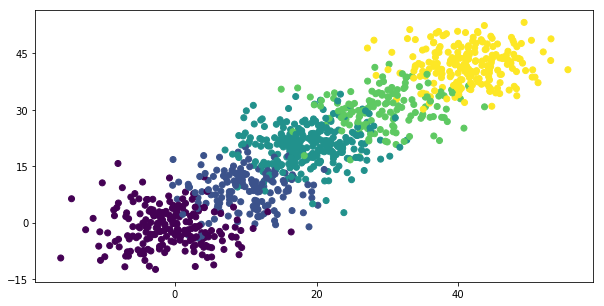

In [5]:
plt_data = obs.reshape((-1, D))
pylab.scatter(plt_data[:, 0], plt_data[:, 1], c=states.reshape(-1))

In [6]:
L = 3
max_iters = 500

In [7]:
# Find best seed for random init
dense_toy_mdl, dense_toy_info = bnpy.run(
    dataset,
    'FiniteHMM', 'DiagGauss', 'VB',
    K=K, output_path=('/tmp/toy/dense-K=%d' % (K)),
    convergeThr=1e-6, nLap=max_iters, printEvery=25, nTask=5)

Dataset Summary:
GroupXData
  size: 100 units (documents)
  dimension: 2
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 2  2] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[ 1.  0.]
   [ 0.  1.]]
Initialization:
  initname = randexamples
  K = 5 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: VB | task  1/5 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/toy/dense-K=5/1
        1/500 after      0 sec. |    118.4 MiB | K    5 | loss  3.861895044e+00 |  
        2/500 after      0 sec. |    118.4 MiB | K    5 | loss  3.789355551e+00 | Ndiff   20.381 
       25/500 after      3 sec. |    118.6 MiB | K    5 | loss  3.759595788e+00 | Ndiff    2.083 
       50/500 after      5 sec. |    118.7 MiB | K    5 | loss  3.754444523e+00 | Ndiff    0.998 
       75/500 after      7 sec. |    118.

In [ ]:
# Find best seed for random init
dense_toy_mdls = []
dense_toy_infos = []
for seed in xrange(5):
    dense_toy_mdl, dense_toy_info = bnpy.run(
        dataset,
        'FiniteHMM', 'DiagGauss', 'VB',
        K=K, output_path=('/tmp/toy/dense-K=%d' % (K)),
        initname='randexamples', taskid=seed,
        convergeThr=1e-6, nLap=max_iters, printEvery=25)
    
    dense_toy_mdls.append(dense_toy_mdl)
    dense_toy_infos.append(dense_toy_info)
    
final_losses = [info['loss_history'][-1] for info in dense_toy_infos]
print final_losses

In [10]:
best_seed = int(dense_toy_info['task_output_path'][-1])

In [11]:
viterbi_toy_mdl, viterbi_toy_info = bnpy.run(
    dataset,
    'FiniteHMM', 'DiagGauss', 'VB',
    K=K, output_path=('/tmp/toy/viterbi-K=%d' % (K)),
    initname='randexamples', taskID=best_seed,
    convergeThr=1e-6, nLap=max_iters, printEvery=25, nnzPerRowLP=1)

Learn Alg: VB | task  4/1 | alg. seed: 8205184 | data order seed: 900864
task_output_path: /tmp/toy/viterbi-K=5/4
        1/500 after      0 sec. |    120.0 MiB | K    5 | loss  3.889159699e+00 |  
        2/500 after      0 sec. |    120.0 MiB | K    5 | loss  3.836330958e+00 | Ndiff   50.000 
        9/500 after      1 sec. |    120.0 MiB | K    5 | loss  3.784064429e+00 | Ndiff    0.000 
... done. converged.


In [ ]:
sparse_toy_mdl, sparse_toy_info = bnpy.run(
    dataset,
    'FiniteHMM', 'DiagGauss', 'VB',
    K=K, output_path=('/tmp/toy/sparse-K=%d' % (K)),
    initname='randexamples', taskID=best_seed,
    convergeThr=1e-6, nLap=max_iters, printEvery=25, nnzPerRowLP=L)

In [30]:
blocked_toy_mdl, blocked_toy_info = bnpy.run(
    dataset,
    'FiniteHMM', 'DiagGauss', 'VB',
    K=K, output_path=('/tmp/toy/blocked-K=%d' % (K)),
    initname='randexamples', taskID=best_seed,
    convergeThr=1e-6, nLap=max_iters, printEvery=25, nnzPerRowLP=L, blockedLP=1)

Learn Alg: VB | task  4/1 | alg. seed: 8205184 | data order seed: 900864
task_output_path: /tmp/toy/blocked-K=5/4
        1/500 after      0 sec. |    124.4 MiB | K    5 | loss  3.887531626e+00 |  
        2/500 after      0 sec. |    124.4 MiB | K    5 | loss  3.781173076e+00 | Ndiff   16.419 
       25/500 after      5 sec. |    124.4 MiB | K    5 | loss  3.718863008e+00 | Ndiff    0.295 
       50/500 after      9 sec. |    124.4 MiB | K    5 | loss  3.718350353e+00 | Ndiff    0.002 
       75/500 after     14 sec. |    124.4 MiB | K    5 | loss  3.718350353e+00 | Ndiff    0.000 
       85/500 after     15 sec. |    124.4 MiB | K    5 | loss  3.718350353e+00 | Ndiff    0.000 
... done. converged.


In [ ]:
pylab.figure()
markersize = 5

pylab.plot(
    viterbi_toy_info['lap_history'],
    viterbi_toy_info['loss_history'], 'r-',
    markersize=markersize,
    label='Viterbi L=1 VB')

pylab.plot(
    sparse_toy_info['lap_history'],
    sparse_toy_info['loss_history'], 'k-',
    markersize=markersize,
    label='Sparse L=%d VB' % L)

pylab.plot(
    blocked_toy_info['lap_history'],
    blocked_toy_info['loss_history'], 'g-',
    markersize=markersize,
    label='"Blocked" sparse L=%d VB' % L)

pylab.plot(
    dense_toy_info['lap_history'],
    dense_toy_info['loss_history'], 'b-',
    markersize=markersize,
    label='Dense VB')

pylab.legend(loc='upper right')

pylab.xlabel('num. laps')
pylab.ylabel('loss: - log p(x)')
pylab.draw()
pylab.tight_layout()

pylab.show()

In [ ]:
# Obtain init and trans matrices
pi0_hat_dense = dense_toy_mdl.allocModel.get_init_prob_vector()
pi_hat_dense = dense_toy_mdl.allocModel.get_trans_prob_matrix()
pi0_hat_sparse = sparse_toy_mdl.allocModel.get_init_prob_vector()
pi_hat_sparse  = sparse_toy_mdl.allocModel.get_trans_prob_matrix()
pi0_hat_blocked = blocked_toy_mdl.allocModel.get_init_prob_vector()
pi_hat_blocked  = blocked_toy_mdl.allocModel.get_trans_prob_matrix()
pi0_hat_viterbi = viterbi_toy_mdl.allocModel.get_init_prob_vector()
pi_hat_viterbi  = viterbi_toy_mdl.allocModel.get_trans_prob_matrix()

In [ ]:
zhat_dense = np.empty_like(states)
zhat_sparse = np.empty_like(states)
zhat_blocked = np.empty_like(states)
zhat_viterbi = np.empty_like(states)
for n in xrange(N):
    ll_seq0_dense = dense_toy_mdl.obsModel.calcLogSoftEvMatrix_FromPost(dataset.make_subset([n]))
    zhat_dense[n] = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
        ll_seq0_dense, np.log(pi0_hat_dense), np.log(pi_hat_dense))
    
    ll_seq0_sparse = sparse_toy_mdl.obsModel.calcLogSoftEvMatrix_FromPost(dataset.make_subset([n]))
    zhat_sparse[n] = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
        ll_seq0_sparse, np.log(pi0_hat_sparse), np.log(pi_hat_sparse))
    
    ll_seq0_blocked = blocked_toy_mdl.obsModel.calcLogSoftEvMatrix_FromPost(dataset.make_subset([n]))
    zhat_blocked[n] = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
        ll_seq0_blocked, np.log(pi0_hat_blocked), np.log(pi_hat_blocked))
    
    ll_seq0_viterbi = viterbi_toy_mdl.obsModel.calcLogSoftEvMatrix_FromPost(dataset.make_subset([n]))
    zhat_viterbi[n] = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(
        ll_seq0_viterbi, np.log(pi0_hat_viterbi), np.log(pi_hat_viterbi))

In [ ]:
zhat_dense_aligned = bnpy.util.StateSeqUtil.alignEstimatedStateSeqToTruth(zhat_dense, states)
zhat_sparse_aligned = bnpy.util.StateSeqUtil.alignEstimatedStateSeqToTruth(zhat_sparse, states)
zhat_blocked_aligned = bnpy.util.StateSeqUtil.alignEstimatedStateSeqToTruth(zhat_blocked, states)
zhat_viterbi_aligned = bnpy.util.StateSeqUtil.alignEstimatedStateSeqToTruth(zhat_viterbi, states)

In [ ]:
from matplotlib import pyplot as plt
plot_ids = np.random.choice(N, replace=True, size=5)
for n in plot_ids:
    fig, ax = plt.subplots()
    im = ax.imshow(np.array([states[n], zhat_dense_aligned[n], zhat_sparse_aligned[n],
                             zhat_blocked_aligned[n], zhat_viterbi_aligned[n]]))
    ax.set_xticks(np.arange(T))
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(['true states',
                        'predicted states - dense',
                        'predicted states - sparse L=%d' % L,
                        'predicted states - blocked L=%d' % L,
                        'predicted states - Viterbi L=1'])
    ax.set_xlabel('t')

In [ ]:
all_zhat_aligned = [zhat_dense_aligned, zhat_sparse_aligned,
                    zhat_blocked_aligned, zhat_viterbi_aligned]
labels = ['dense', 'sparse', 'blocked', 'viterbi']

for label, zhat in zip(labels, all_zhat_aligned):
    print label, bnpy.util.StateSeqUtil.calcHammingDistance(states, zhat)

In [ ]:
def compute_hamming_over_laps(model_path, model_dict):
    distances = np.zeros(len(model_dict['lap_history']))
    
    # Iterate over laps
    for i, lap in enumerate(model_dict['lap_history']):
        # Load allocation and observation models
        try:
            prefix = 'Lap%s.000' % format(lap, "04")
            alloc_model = bnpy.ioutil.ModelReader.load_alloc_model(model_path, prefix)
            obs_model = bnpy.ioutil.ModelReader.load_obs_model(model_path, prefix)
        except:
            # If current iter is unavailable, use previous iter parameters
            pass
    
        # Load parameters
        pi0_hat = alloc_model.get_init_prob_vector()
        pi_hat = alloc_model.get_trans_prob_matrix()
        
        # Viterbi
        zhat = np.empty_like(states)
        for n in xrange(N):
            evidence = obs_model.calcLogSoftEvMatrix_FromPost(dataset.make_subset([n]))
            zhat[n] = bnpy.allocmodel.hmm.HMMUtil.runViterbiAlg(evidence, np.log(pi0_hat), np.log(pi_hat))        
        zhat_aligned = bnpy.util.StateSeqUtil.alignEstimatedStateSeqToTruth(zhat, states)

        # Compute Hamming distance
        distances[i] = bnpy.util.StateSeqUtil.calcHammingDistance(states, zhat_aligned)
        
    return distances

In [ ]:
prefixes = ['/tmp/toy/%s-K=5/%d/' % (s, best_seed) for s in ['viterbi', 'sparse', 'blocked', 'dense']]
info_dicts = [viterbi_toy_info, sparse_toy_info, blocked_toy_info, dense_toy_info]
hams = [compute_hamming_over_laps(prefixes[i], info) for i, info in enumerate(info_dicts)]

In [ ]:
pylab.plot(
    viterbi_toy_info['lap_history'],
    hams[0], 'b-',
    markersize=markersize,
    label='Viterbi L=1 VB')
pylab.plot(
    sparse_toy_info['lap_history'],
    hams[1], 'r-',
    markersize=markersize,
    label='Sparse L=%d VB' % L)
pylab.plot(
    blocked_toy_info['lap_history'],
    hams[2], 'g-',
    markersize=markersize,
    label='"Blocked" sparse L=%d VB' % L)
pylab.plot(
    dense_toy_info['lap_history'],
    hams[3], 'k-',
    markersize=markersize,
    label='Dense VB')

pylab.legend(loc='upper right')

pylab.xlabel('num. laps')
pylab.ylabel('normalized Hamming distance')
pylab.draw()
pylab.tight_layout()

pylab.show()

In [ ]:
bnpy.viz.PlotComps.plotCompsFromHModel(
    dense_toy_mdl,
    dataset=dataset,
    )

In [ ]:
bnpy.viz.PlotComps.plotCompsFromHModel(
    sparse_toy_mdl,
    dataset=dataset,
    )

In [ ]:
bnpy.viz.PlotComps.plotCompsFromHModel(
    blocked_toy_mdl,
    dataset=dataset,
    )

In [ ]:
bnpy.viz.PlotComps.plotCompsFromHModel(
    viterbi_toy_mdl,
    dataset=dataset,
    )

In [9]:
print int(dense_toy_info['task_output_path'][-1])

4


KeyError: 'taskid'

In [12]:
experiment_list = [(dense_toy_mdl, dense_toy_info),
                   (viterbi_toy_mdl, viterbi_toy_info)]

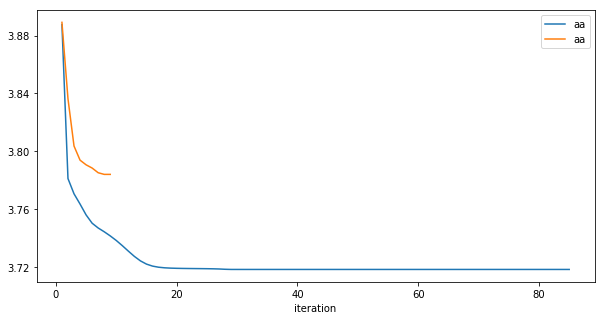

In [15]:
from matplotlib import pyplot as plt
for model, info_dict in experiment_list:
        plt.plot(info_dict['lap_history'], info_dict['loss_history'],
                 label='aa')
        
plt.xlabel('iteration')
plt.legend()

In [34]:
dense_toy_info['KwArgs']['VB']

{'activeonlyLP': 0,
 'algseed': 2986368,
 'blockedLP': 0,
 'convThrLP': 0.01,
 'convergeThr': 1e-06,
 'convergeThrELBO': 0.0001,
 'dataorderseed': 6479872,
 'doShowSeriousWarningsOnly': 1,
 'doSparseOnlyAtFinalLP': 0,
 'initDocTopicCountLP': 'memo',
 'limitMemoryLP': 0,
 'minLaps': 1,
 'nCoordAscentItersLP': 10,
 'nLap': 500,
 'nnzPerRowLP': 0,
 'restartCriteriaLP': 'smallest',
 'restartLP': 0,
 'restartMaxThrLP': 25,
 'restartNumItersLP': 5,
 'restartNumTrialsLP': 5,
 'reviseActiveEveryLP': 1,
 'reviseActiveFirstLP': -1,
 'startLap': 0,
 'verboseLP': 0}

In [41]:
viterbi_toy_info['K_history'][-1]

5

In [36]:
blocked_toy_info['KwArgs']['VB']

{'activeonlyLP': 0,
 'algseed': 8205184,
 'blockedLP': 1,
 'convThrLP': 0.01,
 'convergeThr': 1e-06,
 'convergeThrELBO': 0.0001,
 'dataorderseed': 900864,
 'doShowSeriousWarningsOnly': 1,
 'doSparseOnlyAtFinalLP': 0,
 'initDocTopicCountLP': 'memo',
 'limitMemoryLP': 0,
 'minLaps': 1,
 'nCoordAscentItersLP': 10,
 'nLap': 500,
 'nnzPerRowLP': 3,
 'restartCriteriaLP': 'smallest',
 'restartLP': 0,
 'restartMaxThrLP': 25,
 'restartNumItersLP': 5,
 'restartNumTrialsLP': 5,
 'reviseActiveEveryLP': 1,
 'reviseActiveFirstLP': -1,
 'startLap': 0,
 'verboseLP': 0}